In [54]:
!pip install pytorch_tabnet wget

In [55]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import scipy

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [57]:
import torch
torch.__version__

'2.1.2+cpu'

# Download census-income dataset

In [58]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [59]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [60]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [61]:
train

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,train
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,valid
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [62]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [63]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

/tmp/ipykernel_33/674795864.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'wealthy' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train[target]==0, target] = "wealthy"


# Define categorical features for categorical embeddings

In [64]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Grouped features

You can now specify groups of feature which will share a common attention.

This may be very usefull for features comming from a same preprocessing technique like PCA for example.

In [65]:
len(features)

14

In [66]:
# grouped_features = [[0, 1, 2], [8, 9, 10]]

# Network parameters

In [67]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
#                  "grouped_features" : grouped_features
                }

clf = TabNetClassifier(**tabnet_params
                      )

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [68]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [69]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [70]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [71]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices

sparse_X_train = scipy.sparse.csr_matrix(X_train)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
)

epoch 0  | loss: 0.629   | train_auc: 0.69106 | valid_auc: 0.70194 |  0:00:08s
epoch 1  | loss: 0.5046  | train_auc: 0.83814 | valid_auc: 0.84293 |  0:00:17s
epoch 2  | loss: 0.47066 | train_auc: 0.86678 | valid_auc: 0.86823 |  0:00:26s
epoch 3  | loss: 0.45255 | train_auc: 0.88272 | valid_auc: 0.88338 |  0:00:34s
epoch 4  | loss: 0.44046 | train_auc: 0.89171 | valid_auc: 0.89187 |  0:00:43s
epoch 5  | loss: 0.42714 | train_auc: 0.90196 | valid_auc: 0.90033 |  0:00:52s
epoch 6  | loss: 0.4147  | train_auc: 0.90948 | valid_auc: 0.90786 |  0:01:00s
epoch 7  | loss: 0.40592 | train_auc: 0.91181 | valid_auc: 0.91031 |  0:01:09s
epoch 8  | loss: 0.39773 | train_auc: 0.91655 | valid_auc: 0.9153  |  0:01:18s
epoch 9  | loss: 0.3981  | train_auc: 0.91915 | valid_auc: 0.9184  |  0:01:26s
epoch 10 | loss: 0.38759 | train_auc: 0.92196 | valid_auc: 0.92169 |  0:01:35s
epoch 11 | loss: 0.3812  | train_auc: 0.92458 | valid_auc: 0.92251 |  0:01:43s
epoch 12 | loss: 0.3841  | train_auc: 0.92605 | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [72]:
# This illustrates the warm_start=False behaviour
save_history = []

# Fitting the model without starting from a warm start nor computing the feature importance
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=False
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

save_history = []  # Resetting the list to show that it also works when computing feature importance

# Fitting the model without starting from a warm start but with the computing of the feature importance activated
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
        compute_importance=True # True by default so not needed
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.629   | train_auc: 0.69106 | valid_auc: 0.70194 |  0:00:02s
epoch 1  | loss: 0.5046  | train_auc: 0.83814 | valid_auc: 0.84293 |  0:00:04s
epoch 2  | loss: 0.47066 | train_auc: 0.86678 | valid_auc: 0.86823 |  0:00:06s
epoch 3  | loss: 0.45255 | train_auc: 0.88272 | valid_auc: 0.88338 |  0:00:09s
epoch 4  | loss: 0.44046 | train_auc: 0.89171 | valid_auc: 0.89187 |  0:00:11s
epoch 5  | loss: 0.42714 | train_auc: 0.90196 | valid_auc: 0.90033 |  0:00:13s
epoch 6  | loss: 0.4147  | train_auc: 0.90948 | valid_auc: 0.90786 |  0:00:15s
epoch 7  | loss: 0.40592 | train_auc: 0.91181 | valid_auc: 0.91031 |  0:00:18s
epoch 8  | loss: 0.39773 | train_auc: 0.91655 | valid_auc: 0.9153  |  0:00:20s
epoch 9  | loss: 0.3981  | train_auc: 0.91915 | valid_auc: 0.9184  |  0:00:22s
epoch 10 | loss: 0.38759 | train_auc: 0.92196 | valid_auc: 0.92169 |  0:00:25s
epoch 11 | loss: 0.3812  | train_auc: 0.92458 | valid_auc: 0.92251 |  0:00:27s
epoch 12 | loss: 0.3841  | train_auc: 0.92605 | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.629   | train_auc: 0.69106 | valid_auc: 0.70194 |  0:00:02s
epoch 1  | loss: 0.5046  | train_auc: 0.83814 | valid_auc: 0.84293 |  0:00:04s
epoch 2  | loss: 0.47066 | train_auc: 0.86678 | valid_auc: 0.86823 |  0:00:06s
epoch 3  | loss: 0.45255 | train_auc: 0.88272 | valid_auc: 0.88338 |  0:00:09s
epoch 4  | loss: 0.44046 | train_auc: 0.89171 | valid_auc: 0.89187 |  0:00:11s
epoch 5  | loss: 0.42714 | train_auc: 0.90196 | valid_auc: 0.90033 |  0:00:13s
epoch 6  | loss: 0.4147  | train_auc: 0.90948 | valid_auc: 0.90786 |  0:00:16s
epoch 7  | loss: 0.40592 | train_auc: 0.91181 | valid_auc: 0.91031 |  0:00:18s
epoch 8  | loss: 0.39773 | train_auc: 0.91655 | valid_auc: 0.9153  |  0:00:21s
epoch 9  | loss: 0.3981  | train_auc: 0.91915 | valid_auc: 0.9184  |  0:00:23s
epoch 10 | loss: 0.38759 | train_auc: 0.92196 | valid_auc: 0.92169 |  0:00:25s
epoch 11 | loss: 0.3812  | train_auc: 0.92458 | valid_auc: 0.92251 |  0:00:27s
epoch 12 | loss: 0.3841  | train_auc: 0.92605 | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.629   | train_auc: 0.69106 | valid_auc: 0.70194 |  0:00:02s
epoch 1  | loss: 0.5046  | train_auc: 0.83814 | valid_auc: 0.84293 |  0:00:04s
epoch 2  | loss: 0.47066 | train_auc: 0.86678 | valid_auc: 0.86823 |  0:00:07s
epoch 3  | loss: 0.45255 | train_auc: 0.88272 | valid_auc: 0.88338 |  0:00:09s
epoch 4  | loss: 0.44046 | train_auc: 0.89171 | valid_auc: 0.89187 |  0:00:11s
epoch 5  | loss: 0.42714 | train_auc: 0.90196 | valid_auc: 0.90033 |  0:00:14s
epoch 6  | loss: 0.4147  | train_auc: 0.90948 | valid_auc: 0.90786 |  0:00:16s
epoch 7  | loss: 0.40592 | train_auc: 0.91181 | valid_auc: 0.91031 |  0:00:18s
epoch 8  | loss: 0.39773 | train_auc: 0.91655 | valid_auc: 0.9153  |  0:00:21s
epoch 9  | loss: 0.3981  | train_auc: 0.91915 | valid_auc: 0.9184  |  0:00:23s
epoch 10 | loss: 0.38759 | train_auc: 0.92196 | valid_auc: 0.92169 |  0:00:25s
epoch 11 | loss: 0.3812  | train_auc: 0.92458 | valid_auc: 0.92251 |  0:00:28s
epoch 12 | loss: 0.3841  | train_auc: 0.92605 | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.629   | train_auc: 0.69106 | valid_auc: 0.70194 |  0:00:02s
epoch 1  | loss: 0.5046  | train_auc: 0.83814 | valid_auc: 0.84293 |  0:00:04s
epoch 2  | loss: 0.47066 | train_auc: 0.86678 | valid_auc: 0.86823 |  0:00:06s
epoch 3  | loss: 0.45255 | train_auc: 0.88272 | valid_auc: 0.88338 |  0:00:09s
epoch 4  | loss: 0.44046 | train_auc: 0.89171 | valid_auc: 0.89187 |  0:00:11s
epoch 5  | loss: 0.42714 | train_auc: 0.90196 | valid_auc: 0.90033 |  0:00:13s
epoch 6  | loss: 0.4147  | train_auc: 0.90948 | valid_auc: 0.90786 |  0:00:16s
epoch 7  | loss: 0.40592 | train_auc: 0.91181 | valid_auc: 0.91031 |  0:00:18s
epoch 8  | loss: 0.39773 | train_auc: 0.91655 | valid_auc: 0.9153  |  0:00:20s
epoch 9  | loss: 0.3981  | train_auc: 0.91915 | valid_auc: 0.9184  |  0:00:23s
epoch 10 | loss: 0.38759 | train_auc: 0.92196 | valid_auc: 0.92169 |  0:00:25s
epoch 11 | loss: 0.3812  | train_auc: 0.92458 | valid_auc: 0.92251 |  0:00:27s
epoch 12 | loss: 0.3841  | train_auc: 0.92605 | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


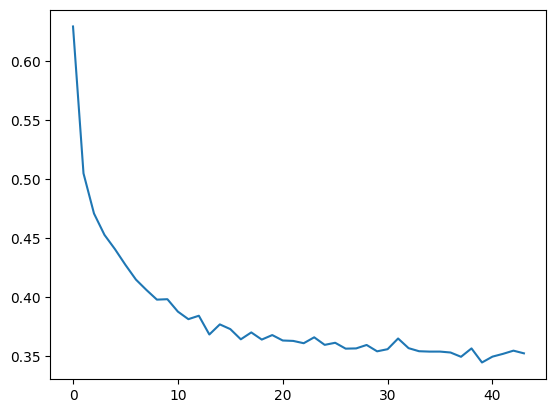

In [73]:
# plot losses
plt.plot(clf.history['loss'])

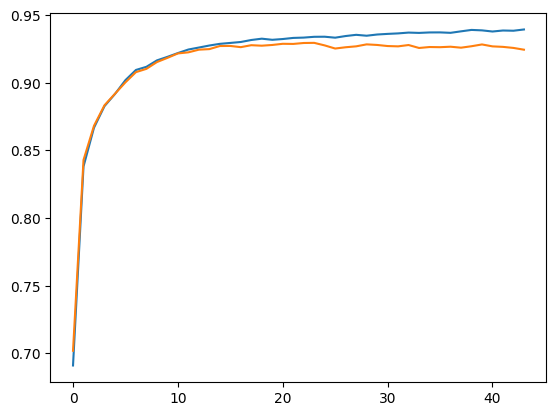

In [74]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

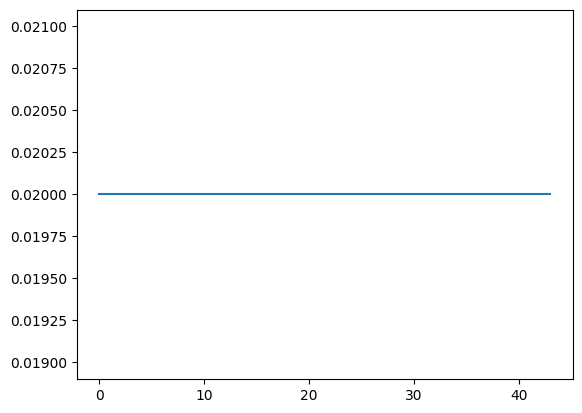

In [75]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [76]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9295122174703326
FINAL TEST SCORE FOR census-income : 0.9249285834742926


In [77]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [78]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [79]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [80]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [81]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9249285834742926


In [82]:
assert(test_auc == loaded_test_auc)

In [83]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [84]:
clf.feature_importances_

array([0.03715121, 0.00993689, 0.01114183, 0.0218374 , 0.16066859,
       0.30369436, 0.08902133, 0.09850678, 0.01823299, 0.00992545,
       0.13654407, 0.04422278, 0.05581133, 0.003305  ])

# Local explainability and masks

In [85]:
explain_matrix, masks = clf.explain(X_test)

/tmp/ipykernel_33/2446531049.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels = features, rotation=45)


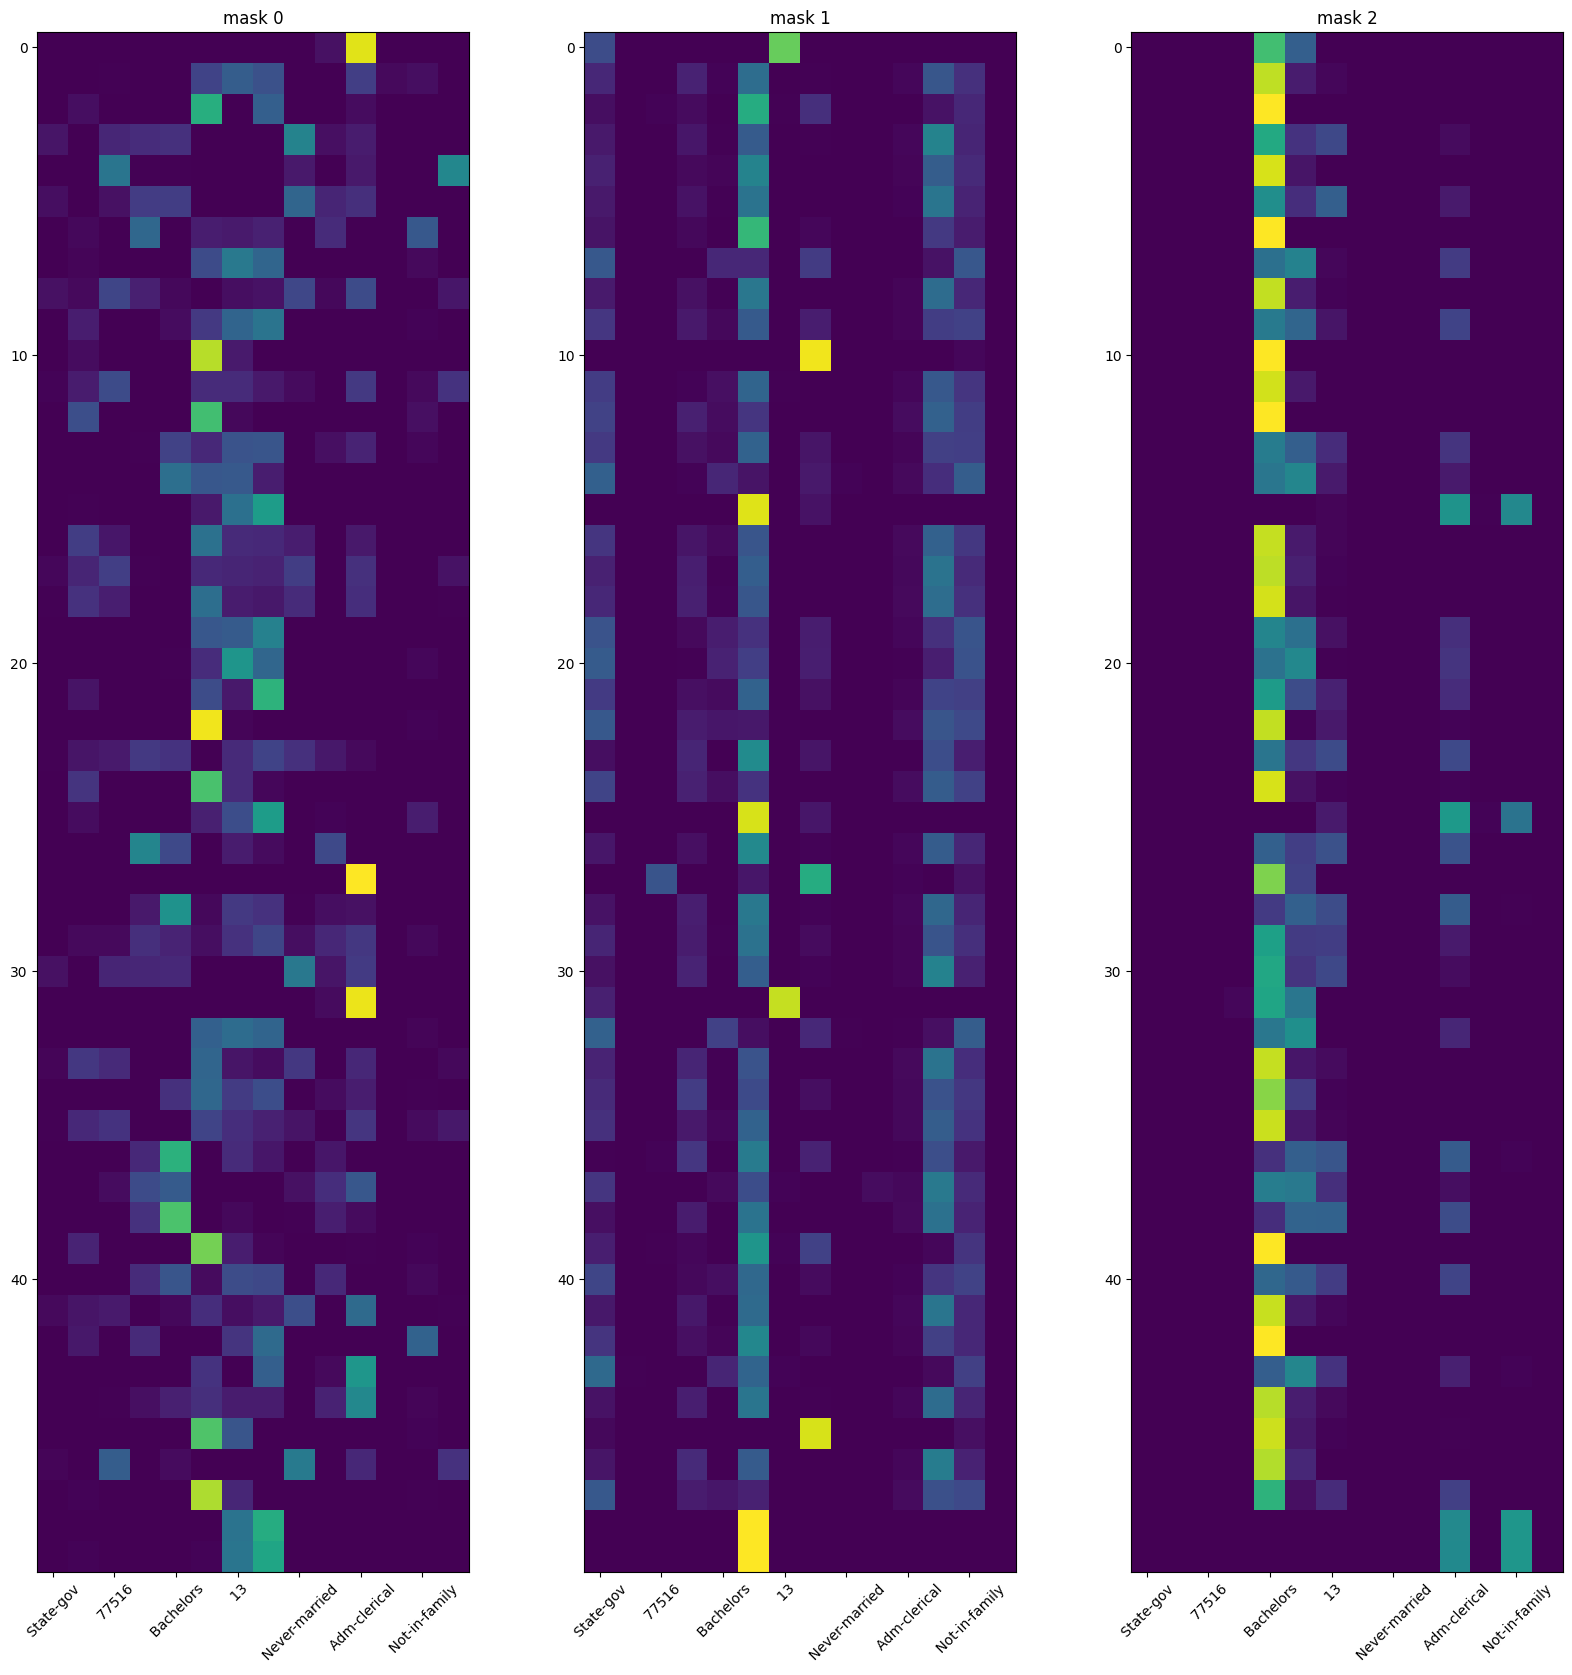

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = features, rotation=45)

# AUTOENCODER

In [87]:
from pytorch_tabnet.pretraining import TabNetPretrainer
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [88]:
max_epochs = 150 if not os.getenv("CI", False) else 2 # 1000

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 7.45025 | val_0_unsup_loss_numpy: 8.615659713745117|  0:00:01s
epoch 5  | loss: 1.08586 | val_0_unsup_loss_numpy: 1.093459963798523|  0:00:09s
epoch 10 | loss: 1.06015 | val_0_unsup_loss_numpy: 1.0323799848556519|  0:00:17s
epoch 15 | loss: 0.99372 | val_0_unsup_loss_numpy: 0.9322800040245056|  0:00:25s
epoch 20 | loss: 0.95409 | val_0_unsup_loss_numpy: 0.8870000243186951|  0:00:33s
epoch 25 | loss: 0.93737 | val_0_unsup_loss_numpy: 0.843720018863678|  0:00:41s
epoch 30 | loss: 0.91204 | val_0_unsup_loss_numpy: 0.8298100233078003|  0:00:49s
epoch 35 | loss: 0.89489 | val_0_unsup_loss_numpy: 0.796970009803772|  0:00:57s
epoch 40 | loss: 0.88902 | val_0_unsup_loss_numpy: 0.7680400013923645|  0:01:05s
epoch 45 | loss: 0.87124 | val_0_unsup_loss_numpy: 0.7497900128364563|  0:01:13s
epoch 50 | loss: 0.85233 | val_0_unsup_loss_numpy: 0.7445099949836731|  0:01:22s
epoch 55 | loss: 0.84846 | val_0_unsup_loss_numpy: 0.7332000136375427|  0:01:30s
epoch 60 | loss: 0.83164 | val_0

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [89]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_train)
reconstructed_X_valis, embedded_X_valid = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [91]:
# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
tabnet_params = {
#                     "cat_idxs":cat_idxs,
#                  "cat_dims":cat_dims,
#                  "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
#                  "grouped_features" : grouped_features
                }

clf_latent = TabNetClassifier(**tabnet_params
                      )

sparse_X_train = scipy.sparse.csr_matrix(embedded_X)  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(embedded_X_valid)  # Create a CSR matrix from X_valid

# Fitting the model
clf_latent.fit(
    X_train=sparse_X_train, y_train=y_train,
    eval_set=[(sparse_X_train, y_train), (sparse_X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug, #aug, None
)

epoch 0  | loss: 0.52144 | train_auc: 0.85482 | valid_auc: 0.86817 |  0:00:08s
epoch 1  | loss: 0.43909 | train_auc: 0.87811 | valid_auc: 0.88666 |  0:00:17s
epoch 2  | loss: 0.42002 | train_auc: 0.89026 | valid_auc: 0.89928 |  0:00:26s
epoch 3  | loss: 0.40973 | train_auc: 0.89798 | valid_auc: 0.90244 |  0:00:34s
epoch 4  | loss: 0.40943 | train_auc: 0.90021 | valid_auc: 0.90377 |  0:00:43s
epoch 5  | loss: 0.40902 | train_auc: 0.90348 | valid_auc: 0.90866 |  0:00:52s
epoch 6  | loss: 0.40202 | train_auc: 0.90619 | valid_auc: 0.91042 |  0:01:01s
epoch 7  | loss: 0.39993 | train_auc: 0.90756 | valid_auc: 0.91031 |  0:01:10s
epoch 8  | loss: 0.399   | train_auc: 0.90822 | valid_auc: 0.91152 |  0:01:18s
epoch 9  | loss: 0.40424 | train_auc: 0.90956 | valid_auc: 0.91205 |  0:01:28s
epoch 10 | loss: 0.39314 | train_auc: 0.91078 | valid_auc: 0.91097 |  0:01:36s
epoch 11 | loss: 0.39312 | train_auc: 0.91201 | valid_auc: 0.91159 |  0:01:45s
epoch 12 | loss: 0.39709 | train_auc: 0.9125  | vali

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


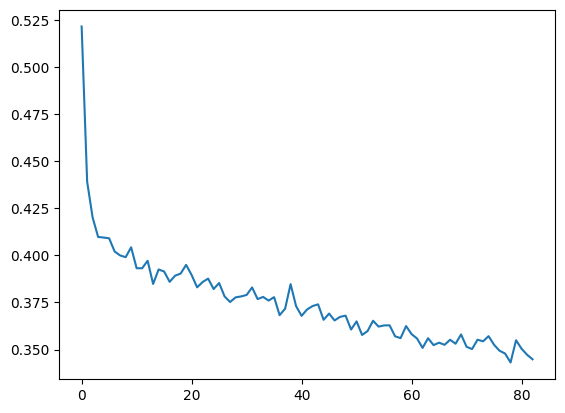

In [92]:
plt.plot(clf_latent.history['loss'])

In [93]:
# preds = clf.predict_proba(X_test)
# test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf_latent.predict_proba(sparse_X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf_latent.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9207126981996092
FINAL TEST SCORE FOR census-income : 0.9249285834742926


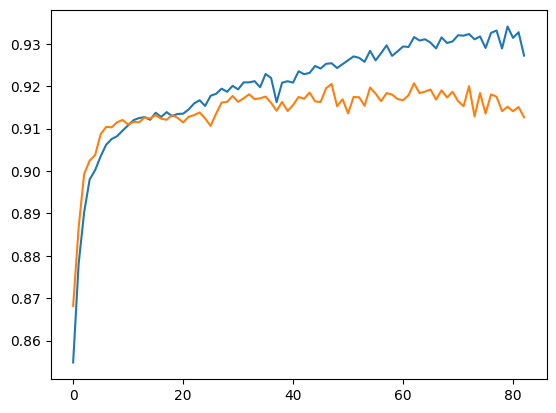

In [94]:
# plot auc
plt.plot(clf_latent.history['train_auc'])
plt.plot(clf_latent.history['valid_auc'])